# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

## Import and definition of prediction function:

In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import input_queues as iq
import plot_helpers as plt_help
import cnn_helpers as chlp


__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

__all__ = ['predict']

# make only 'gpu:0' visible, so that only one gpu is used not both, see also
# https://github.com/tensorflow/tensorflow/issues/5066
# https://github.com/tensorflow/tensorflow/issues/3644#issuecomment-237631171
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

data_dir = '/media/sdb/udo/data/'

In [2]:
def predict(image, path_inference_graph, checkpoint_path,
            nodes_name_dict, plot_inference_graph=False):
    """
    :param image:
    :type image:
    :param path_inference_graph: path to inference graph (graph without 
        'training' ops)
    :type path_inference_graph: str
    :param checkpoint_path: path to model parameters (checkpoint files
        e.g. 'logs/2/tfmodel-5')
    :type checkpoint_path: str
    :param nodes_name_dict: dictionary that contains name of input, albedo and 
        shading output in form {'input': '', 
                                'output_albedo': '',
                                'output_shading': ''}
    :type nodes_name_dict: dict
    :param plot_inference_graph: flag, True if inference graph should be 
        plotted (default: False).
    :type plot_inference_graph: boolean

    :return: prediction albedo layer, prediction shading layer
    """
    # clear default graph:
    tf.reset_default_graph()
     
    # import meta (inference) graph:
    meta_graph = tf.train.import_meta_graph(path_inference_graph,
                                            clear_devices=True)
    # save default graph in variable:
    graph = tf.get_default_graph()
    if plot_inference_graph:
        # plot imported inference graph:
        plt_help.show_graph(graph.as_graph_def())

    ############################################################################
    ############################################################################
    # defining input/output nodes:

    # lets get the input
    x = graph.get_tensor_by_name(name=nodes_name_dict['input'])

    # bool variable that indicates if we are in training mode (training=True) or
    # valid/test mode (training=False) this indicator is important if dropout 
    # or/and batch normalization is used.
    try:
        # try importing training node (is needed for models that use batch 
        # normalization etc.)
        training = graph.get_tensor_by_name(name='is_training:0')
    except KeyError:
        # elsewise just define a placeholder wich is used as dummy variable
        # and won't be used later:
        training = tf.placeholder(dtype=tf.bool, name='is_training')

    # get graph output nodes:
    y_albedo_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_albedo'])
    y_shading_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_shading'])

    # y_albedo_pred = tf.clip_by_value(t=y_albedo, clip_value_min=0, 
    #                                  clip_value_max=1, 
    #                                  name='0_1_clipping_albedo')
    # y_shading_pred = tf.clip_by_value(t=y_shading, clip_value_min=0,
    #                                   clip_value_max=1, 
    #                                   name='0_1_clipping_shading')

    ############################################################################
    ############################################################################
    # making prediction:
    config = tf.ConfigProto(device_count = {'GPU': 1},
                            intra_op_parallelism_threads=3)
    with tf.Session(config=config) as sess: 
        # Restore variables from disk.
        meta_graph.restore(sess, checkpoint_path)
        # make predictions:
        feed_dict = {x: image, 
                     training: False}

        pred_alb, pred_shad = sess.run([y_albedo_pred, y_shading_pred],
                                       feed_dict=feed_dict)
    
    return pred_alb, pred_shad

## Predictions for Sintel dataset:
### Load Sintel dataset:

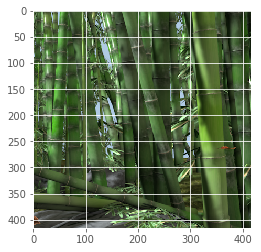

In [3]:
# testing data set:
file_sintel = 'data_sintel_shading_test.csv'
df_test_sintel = pd.read_csv(data_dir + file_sintel, sep=',', header=None,
                             names=['img', 'alb', 'shad', 'invalid'])
# compolete image paths:
df_test_sintel = data_dir + df_test_sintel

# # get one test image path (and its ground truth labels):
# df_image_paths_sintel = df_test_sintel.loc[[12], ['img', 'alb', 'shad']]

# import one image:
lst = iq.next_batch_sintel(deq=df_test_sintel,
                           output_shape=[32 * 13, 32 * 13, 3],
                           is_scale=False,
                           is_flip=False,
                           is_rotated=False,
                           norm=True)
img_sintel_b, alb_sintel_b, shad_sintel_b, inv_sintel_b = lst
plt.imshow(img_sintel_b[0])

### Perform predictions on sintel dataset:

In [4]:
# slim_resnet_v1_50_deconv_decoder/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50/tfmodel_inference.meta',
          'checkpoint_path': '/media/sdb/udo/logs/sintel/slim_resnet_v1_50_deconv_decoder/2/tfmodel-8600',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

In [5]:
pred_alb, pred_shad = predict(image=img_sintel_b, **params)

INFO:tensorflow:Restoring parameters from /media/sdb/udo/logs/sintel/slim_resnet_v1_50_deconv_decoder/2/tfmodel-8600


InternalError: Dst tensor is not initialized.
	 [[Node: save/RestoreV2_31/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_676_save/RestoreV2_31", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

In [ ]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[img_sintel_b[i], 
                             alb_sintel_b[i], 
                             pred_alb[i], 
                             shad_sintel_b[i], 
                             pred_shad[i]],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

In [6]:
tf.reset_default_graph()
batch_size = 16

ph_input_image = tf.placeholder(dtype=tf.float32, name='input_image')
ph_label_albedo = tf.placeholder(dtype=tf.float32, name='label_albedo')
ph_label_shading = tf.placeholder(dtype=tf.float32, name='label_shading')
ph_prediction_albedo = tf.placeholder(dtype=tf.float32, name='prediction_albedo')
ph_prediction_shading = tf.placeholder(dtype=tf.float32, name='prediction_shading')
ph_valid_mask = tf.placeholder(dtype=tf.float32, name='valid_mask')

d = {'label_albedo': ph_label_albedo,
     'label_shading': ph_label_shading,
     'prediction_albedo': ph_prediction_albedo, 
     'prediction_shading': ph_prediction_shading,
     'valid_mask': ph_valid_mask}

loss_dict = {'berhu': chlp.sintel_loss_fct(**d, **{'loss_type': 'berhu', 
                                                   'lambda_': None}),
             'l1': chlp.sintel_loss_fct(**d, **{'loss_type': 'l1',
                                                'lambda_': None}),
             'l2': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2', 
                                                'lambda_': 0}),
             'l2_inv': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                    'lambda_': 1}),
             'l2_avg': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                    'lambda_': 0.5}),
             'berhu_general': chlp.berhu_loss(label=ph_input_image,
                                              prediction=ph_prediction_albedo*ph_prediction_shading,
                                              valid_mask=ph_valid_mask),
             'l1_general': chlp.l1_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        valid_mask=ph_valid_mask),
             'l2_general': chlp.l2_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        lambda_=0,
                                        valid_mask=ph_valid_mask)
            }

# define the sintel dataset loss dict:
valid_dict = {key: tf.placeholder(dtype=tf.float32, name=key) for \
              key in loss_dict.keys()}

In [7]:
# Validation:
config = tf.ConfigProto(device_count = {'GPU': 1},
                           intra_op_parallelism_threads=3)
with tf.Session(config=config) as sess: 
    valid_mask = chlp.get_valid_pixels(image=img_sintel_b, 
                                       invalid_mask=inv_sintel_b)
    valid_mask = sess.run(valid_mask)

    # use the complete test data set to calculate the error/accuracy on the
    # test set above:
    # loop through one data set epoch:
    # initialize dictionary which contains all losses:
    valid_loss_dict = dict.fromkeys(loss_dict, 0)
    valid_steps_per_epoch = int(img_sintel_b.shape[0] / 
                                batch_size)
    batch_limits = list(range(0, img_sintel_b.shape[0], batch_size)) + [img_sintel_b.shape[0] - 1]
    for i in range(len(batch_limits) - 1):
        # calculate the mean loss of this validation batch and 
        # sum it with the previous mean batch losses:
        fd_val = {ph_input_image: img_sintel_b[batch_limits[i]:batch_limits[i+1]],
                  ph_label_albedo: alb_sintel_b[batch_limits[i]:batch_limits[i+1]],
                  ph_label_shading: shad_sintel_b[batch_limits[i]:batch_limits[i+1]],
                  ph_prediction_albedo: pred_alb[batch_limits[i]:batch_limits[i+1]], 
                  ph_prediction_shading: pred_shad[batch_limits[i]:batch_limits[i+1]],
                  ph_valid_mask: valid_mask[batch_limits[i]:batch_limits[i+1]]}

        for key, val in loss_dict.items():
            # divide each loss loss by the iteration steps 
            # (steps_per_epoch) to get the mean val loss:
            mean_val = val / valid_steps_per_epoch
            val_eval, mean_val_eval = sess.run([val, mean_val], feed_dict=fd_val)
            valid_loss_dict[key] += mean_val_eval        

In [8]:
valid_loss_dict

{'berhu': 0.32961474359035492,
 'berhu_general': 0.083590373396873474,
 'l1': 0.28960788249969482,
 'l1_general': 0.079964999109506607,
 'l2': 0.070080811157822609,
 'l2_avg': 0.045251608826220036,
 'l2_general': 0.012360239634290338,
 'l2_inv': 0.020422406494617462}

## Predictions for Sintel dataset
### Load IIW dataset:

/home/users/dehm/image_decomposition/input_queues.py:794: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['x'] = (df_point_crop['x'] * img.shape[1] - x_start) / output_shape[1]
/home/users/dehm/image_decomposition/input_queues.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['y'] = (df_point_crop['y'] * img.shape[0] - y_start) / output_shape[0]
/home/users/dehm/image_decomposition/input_queues.py:842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

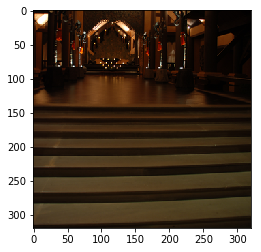

In [2]:
file_iiw = 'data_iiw_test.csv'
df_test_iiw = pd.read_csv(filepath_or_buffer=data_dir + file_iiw, 
                          sep=',', header=None,
                          names=['img', 'json_label'])
# complete image paths:
df_test_iiw = data_dir + df_test_iiw
# # get one test image path (and its ground truth labels):
# df_image_paths_iiw = df_test_iiw.loc[[1], ['img', 'json_label']]

# import one image:
df_iiw, images_iiw, images_original_iiw, js_labels_iiw, js_labels_original_iiw = iq.next_batch_iiw(deq=df_test_iiw.loc[:100,:],
                                                                                                   output_shape=[320, 320, 3],
                                                                                                   norm=True)
plt.imshow(images_iiw[0])

### Perform predictions on iiw dataset:

In [3]:
# slim_resnet_v1_50_deconv_decoder/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50/tfmodel_inference.meta',
          'checkpoint_path': 'logs/iiw/slim_resnet_v1_50_deconv_decoder/l1_10mhdl/2/tfmodel-7000',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

In [4]:
pred_alb, pred_shad = predict(image=images_iiw, **params)

INFO:tensorflow:Restoring parameters from logs/iiw/slim_resnet_v1_50_deconv_decoder/l1_10mhdl/2/tfmodel-7000


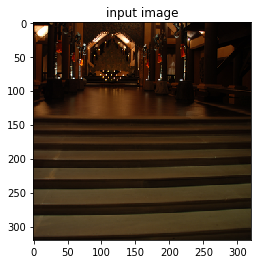

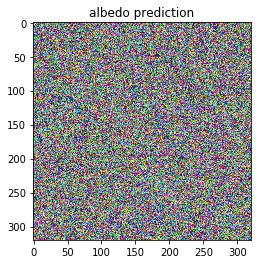

ValueError: Floating point image RGB values must be in the 0..1 range.

In [5]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[images_iiw[i], 
                             pred_alb[i], 
                             pred_shad[i]],
                     titles=['input image', 
                             'albedo prediction', 
                             'shading prediction'])

In [13]:
lambda_loss = 1.0
ph_input_image = tf.placeholder(dtype=tf.float32, name='input_image')
ph_prediction_albedo = tf.placeholder(dtype=tf.float32, name='prediction_albedo')
ph_prediction_shading = tf.placeholder(dtype=tf.float32, name='prediction_shading')
point1 = tf.placeholder(dtype=tf.int32, name='point1')
point2 = tf.placeholder(dtype=tf.int32, name='point2')
# get the human darker labels:
human_labels = tf.placeholder(dtype=tf.int32, name='human_labels')
# list of weights/darker scores:
darker_weights = tf.placeholder(dtype=tf.float32, name='darker_weights')

losses_iiw = chlp.iiw_loss_fct(input_image=ph_input_image,
                               prediction_albedo=ph_prediction_albedo,
                               prediction_shading=ph_prediction_shading,
                               albedo_comp_point1=point1,
                               albedo_comp_point2=point2,
                               albedo_comp_human_labels=human_labels,
                               albedo_comp_weights=darker_weights,
                               albedo_comp_delta=0.1,
                               lambda_=lambda_loss)

loss_dict = {'l1_mhdl': losses_iiw[0],
             'l1_mwhdl': losses_iiw[1],
             'l2_mhdl': losses_iiw[2],
             'l2_mwhdl': losses_iiw[3],
             'l1': losses_iiw[4],
             'l2': losses_iiw[5],
             'mhdl': losses_iiw[6],
             'mwhdl': losses_iiw[7],
             'berhu_general': chlp.berhu_loss(label=ph_input_image,
                                              prediction=ph_prediction_albedo*ph_prediction_shading,
                                              valid_mask=None),
             'l1_general': chlp.l1_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        valid_mask=None),
             'l2_general': chlp.l2_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        lambda_=0,
                                        valid_mask=None)
            }

In [14]:
config = tf.ConfigProto(device_count = {'GPU': 1},
                        intra_op_parallelism_threads=3)
with tf.Session(config=config) as sess: 
    fd = {ph_input_image: images_iiw,
          ph_prediction_albedo: pred_alb,
          ph_prediction_shading: pred_shad,
          point1: df_iiw[['batch_nr', 'y1', 'x1']].values,
          point2: df_iiw[['batch_nr', 'y2', 'x2']].values,
          human_labels: df_iiw['darker'].values,
          darker_weights: df_iiw['darker_score'].values
         }
    # run optimization step:
    losses_iiw_results = sess.run(loss_dict, feed_dict=fd)

In [15]:
losses_iiw_results

{'l1': 328858.81,
 'l1_mhdl': 330047.69,
 'l1_mwhdl': 329701.25,
 'l2': 1.9749451e+13,
 'l2_mhdl': 1.9749451e+13,
 'l2_mwhdl': 1.9749451e+13,
 'mhdl': 1188.8892,
 'mwhdl': 842.44788}

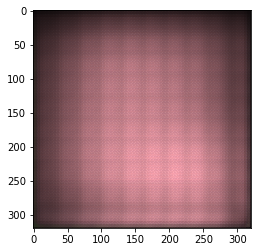

In [15]:
plt.imshow((pred_alb[0] - pred_alb[0].min())/ (pred_alb[0].max()-pred_alb[0].min()))

In [17]:
# !tensorboard --logdir ./logs/camp/2

## resizing an image

In [7]:
import scipy as sp

In [10]:
images[0].reshape(params['image_shape']).shape

(416, 416, 3)

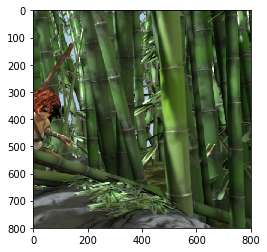

In [16]:
plt.imshow(sp.misc.imresize(arr=images[0].reshape(params['image_shape']),
                 size=(800, 800, 3), interp='bilinear', mode=None))

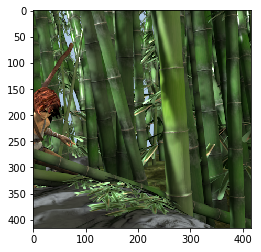

In [17]:
plt.imshow(images[0].reshape(params['image_shape']))